## Predicated range delay from troposphere based on ERA5

+ ERA5
  - 0.25 deg spatial resolution
  - 1-hour temporal resolution


+ reference geometry:
  - use incidence angle, latitude and longitude of the scene center
  - use terrain height for vertical integration.


+ tropospheric components:
  - Dry troposphere: large absolute value with little variation
  - Wet troposphere: small absolute value with large  variation
  - comb (dry + wet) delay is used.

In [10]:
%matplotlib inline
import os
import pickle
import numpy as np
from matplotlib import pyplot as plt
from mintpy.objects import timeseries
from mintpy.utils import ptime, readfile, utils as ut, plot as pp, isce_utils
from mintpy import tropo_pyaps3, view
import pyaps3 as pa
plt.rcParams.update({'font.size': 12})
figsize = [12, 4]

proj_dir = '/Users/yunjunz/data/ChileSenAT149'
os.chdir(proj_dir)
print('Go to directory', proj_dir)

mintpy_dir = os.path.join(proj_dir, 'mintpyOffset')
out_file = os.path.join(proj_dir, 'offset_comp/era5.pickle')

Go to directory /Users/yunjunz/data/ChileSenAT149


### 1. calc tropo delay based on `terrain height` and `real DEM`

extract metadata from ISCE/topsStack xml file: /Users/yunjunz/data/ChileSenAT149/reference/IW1.xml
terrain height: 2176.0 m
file already exists: /Users/yunjunz/data/ChileSenAT149/mintpyOffset/inputs/ERA5_constHgt.h5
file already exists: /Users/yunjunz/data/ChileSenAT149/mintpyOffset/inputs/ERA5_constHgt_dry.h5
file already exists: /Users/yunjunz/data/ChileSenAT149/mintpyOffset/inputs/ERA5_constHgt_wet.h5
file already exists: /Users/yunjunz/data/ChileSenAT149/mintpyOffset/inputs/ERA5.h5
file already exists: /Users/yunjunz/data/ChileSenAT149/mintpyOffset/inputs/ERA5_dry.h5
file already exists: /Users/yunjunz/data/ChileSenAT149/mintpyOffset/inputs/ERA5_wet.h5
Done.
run view.py in MintPy release version v1.2.3-29, release date 2020-08-26
input file is geometry file: /Users/yunjunz/data/ChileSenAT149/mintpyOffset/inputs/geometryRadar.h5 in float32 format
file size in y/x: (122, 231)
input dataset: "['height']"
num of datasets in file geometryRadar.h5: 8
datasets to exclude (0):
[]
datasets 

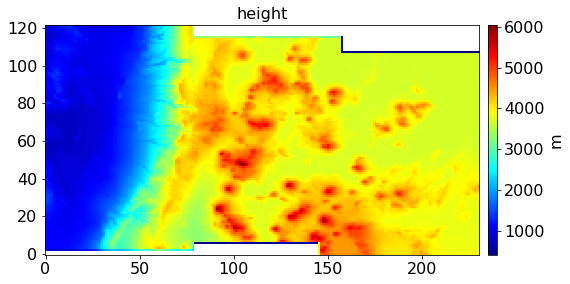

In [17]:
# required input files
ts_files = [
    os.path.join(mintpy_dir, 'inputs/ERA5_constHgt.h5'),
    os.path.join(mintpy_dir, 'inputs/ERA5_constHgt_dry.h5'),
    os.path.join(mintpy_dir, 'inputs/ERA5_constHgt_wet.h5'),
    os.path.join(mintpy_dir, 'inputs/ERA5.h5'),
    os.path.join(mintpy_dir, 'inputs/ERA5_dry.h5'),
    os.path.join(mintpy_dir, 'inputs/ERA5_wet.h5'),
]
geom_file = os.path.join(mintpy_dir, 'inputs/geometryRadar.h5')

# get terrain height
xml_file = os.path.join(proj_dir, 'reference/IW1.xml')
burst = isce_utils.extract_isce_metadata(xml_file)[1]
print('terrain height: {} m'.format(burst.terrainHeight))

# calculate absolute tropospheric delay from ERA5
delay_types = ['comb', 'dry', 'wet']
for i in range(len(ts_files)):
    if not os.path.isfile(ts_files[i]):
        sar_file = os.path.join(mintpy_dir, 'timeseriesRg.h5')
        iargs = ['-f', sar_file,
                 '-g', geom_file,
                 '--delay', delay_types[i],
                 '--tropo-file', ts_files[i]]
        if i < 3:
            iargs += ['--custom-height', str(burst.terrainHeight)]
        print('tropo_pyaps3.py', ' '.join(iargs))
        tropo_pyaps3.main(iargs)
    else:
        print('file already exists: {}'.format(ts_files[i]))
print('Done.')

# plot the real DEM for reference
view.main([geom_file, 'height', '--zero-mask'])

### 2. save to pickle file

In [7]:
# read data
date_list = timeseries(ts_files[0]).get_date_list()
num_date = len(date_list)
ts_data_list = []
for ts_file in ts_files:
    ts_data = readfile.read(ts_file)[0].reshape(num_date, -1)
    # exclude pixels with no-valid data
    ts_data[ts_data == 0] = np.nan
    # reverse back the sign because it was reversed in tropo_pyaps3.py#L584
    ts_data *= -1
    ts_data_list.append(ts_data)

# calculate median and mean
atr = readfile.read_attribute(ts_files[0])
length, width = int(atr['LENGTH']), int(atr['WIDTH'])
ind_cen = int(length / 2) * width + int(width / 2)

## compose off dict
tropo = {}
tropo['date'] = np.array(date_list)
tropo['time'] = np.array(ptime.date_list2vector(date_list)[0])
# calc based on terrain height
tropo['range_delay_tropo_cHgtCen']     = ts_data_list[0][:, ind_cen]
tropo['range_delay_tropo_cHgtCen_dry'] = ts_data_list[1][:, ind_cen]
tropo['range_delay_tropo_cHgtCen_wet'] = ts_data_list[2][:, ind_cen]
# calc based on real DEM
tropo['range_delay_tropo_vHgtMed']     = np.nanmedian(ts_data_list[3], axis=-1)
tropo['range_delay_tropo_vHgtMed_dry'] = np.nanmedian(ts_data_list[4], axis=-1)
tropo['range_delay_tropo_vHgtMed_wet'] = np.nanmedian(ts_data_list[5], axis=-1)

## save off dict to pickle file
with open(out_file, 'wb') as f:
    pickle.dump(tropo, f)
    print('save data to file: {}'.format(out_file))

save data to file: /Users/yunjunz/data/ChileSenAT149/offset_comp/era5.pickle


### 3. plot (variation between dry and wet troposphere)

save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/TS_era5_cHgtCen.png


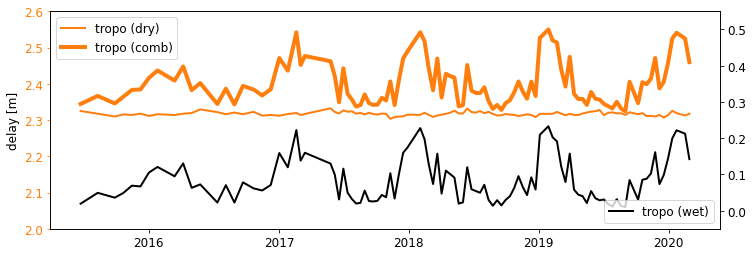

save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/TS_era5_vHgtMed.png


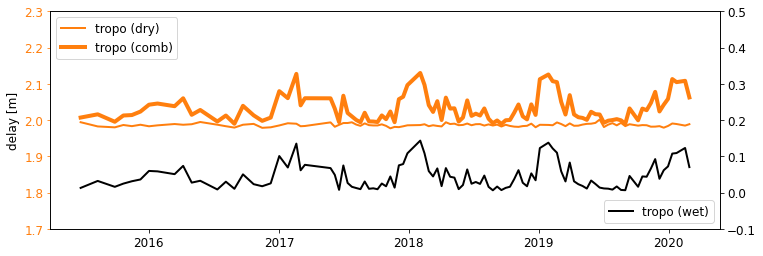

In [18]:
for opt in ['cHgtCen', 'vHgtMed']:
    key_base = 'range_delay_tropo_{}'.format(opt)

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(tropo['time'], tropo[key_base+'_dry'], '-', linewidth=2, color='C1', label='tropo (dry)')
    ax.plot(tropo['time'], tropo[key_base],        '-', linewidth=4, color='C1', label='tropo (comb)')
    ax.tick_params(which='both', axis='y', colors='C1')
    ax.set_ylabel('delay [m]')
    ax.legend(loc='upper left')

    ax2 = ax.twinx()
    ax2.plot(tropo['time'], tropo[key_base+'_wet'], '-', linewidth=2, color='k', label='tropo (wet)')
    ax2.tick_params(which='both', axis='y', colors='k')
    ax2.legend(loc='lower right')

    if opt == 'cHgtCen':
        ax.set_ylim(2.0, 2.6)
        ax2.set_ylim(-0.05, 0.55)
    else:
        ax.set_ylim(1.7, 2.3)
        ax2.set_ylim(-0.1, 0.5)

    # output
    out_fig = os.path.join(os.path.dirname(out_file), 'TS_era5_{}.png'.format(opt))
    print('save figure to file', out_fig)
    plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
    plt.show()

### Obsolete 2.1: plot variance between `median`, `mean` and `scene center`

In [ ]:
times = np.array(ptime.date_list2vector(date_list)[0])

fig, ax = plt.subplots(figsize=figsize)
ax.plot(times, tropo_cen, linewidth=4, color='gray', label='tropo (center)')
ax.plot(times, tropo_avg, linewidth=4, color='k',    label='tropo (mean)')
ax.plot(times, tropo_med, linewidth=4, color='C2',   label='tropo (median)')
pp.auto_adjust_xaxis_date(ax, times, every_year=1, buffer_year=None)
ax.set_ylabel('range delay [m]')
plt.legend()

# output
out_fig = os.path.join(os.path.dirname(out_file), 'TS_era5_stats.png')
print('save figure to file', out_fig)
#plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### Obsolete 2.2: plot difference between `median-mean` and `median-center`

In [ ]:
# plot median / mean / center difference
fig, ax = plt.subplots(figsize=figsize)
ax.plot(times, tropo_med - tropo_avg, linewidth=4, color='k',    label='tropo (median - mean)')
ax.plot(times, tropo_med - tropo_cen, linewidth=4, color='gray', label='tropo (median - scene center)')
ax.set_ylabel('delay [m]')
plt.legend()

# output
out_fig = os.path.join(os.path.dirname(out_file), 'TS_era5_stats_diff.png')
print('save figure to file', out_fig)
#plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()